# Imports

In [3]:
%load_ext autoreload
%autoreload 2
import warnings
from numba.core.errors import NumbaDeprecationWarning
warnings.filterwarnings("ignore", category=NumbaDeprecationWarning)

%run ../../setup_project.py
%run ../../generic_plot_functions.py
%run neuronAutopi.py

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
sns.__version__

'0.12.2'

In [5]:
projectName, dataPath, dlcModelPath, myProject, sSessions= setup_project_session_lists(projectName="autopi_mec",dataPath=PROJECT_DATA_PATH,dlcModelPath="")

creating myProject, an autopipy.project object
Project name: autopi_mec
dataPath: /ext_drives/d91/data/projects/jingjie/dyrad_data_files
dlcModelPath: 
Reading /ext_drives/d91/data/projects/jingjie/dyrad_data_files/sessionList
We have 180 testing sessions in the list
spikeA.Kilosort_session objects are in sSessions


# Prepare data

In [6]:
fn = myProject.dataPath+"/results/myMaps.pickle" #, dictionary with key per condition
with open(fn, 'rb') as handle:
    myMaps = pickle.load(handle)

In [ ]:
fn=myProject.dataPath+"/results/cells.csv"
cells = pd.read_csv(fn)

In [9]:
fn = myProject.dataPath+"/results/myLeverMaps.pickle" #, dictionary with key per condition
with open(fn, 'rb') as handle:
   myLeverMaps = pickle.load(handle)

# Functions

In [10]:
sessionList = myProject.sessionList

In [11]:
def load_ifr_behavior(ses,verbose=False):
    """
    Load data files for a session that we need to correlate ifr and navpath variables
    
    ifr_autopi.pkl: the instantaneous firing rate of all neurons as a function of time. 
    navPathSummary.csv: description of navPath that can be analyzed
    navPathInstan.csv: contains variables that changes within a single navPath (e.g., distance run and speed)
    
    """
    fn = ses.path+"/ifr_autopi.pkl"
    if verbose:
        print("loading",fn)
    with open(fn, 'rb') as intp:
        ifr = pickle.load(intp)
    
    fn = ses.path+"/navPathSummary.csv"
    if verbose:
        print("loading",fn)
    navPathSummary = pd.read_csv(fn)
    
    fn = ses.path+"/navPathInstan.csv"
    if verbose:
        print("loading",fn)
    navPathInstan = pd.read_csv(fn)
    
    
    # all the timeRes values in our navPathInstan should be in IFR time array
    intol = isin_tolerance(navPathInstan.timeRes,ifr[1],tol=0.00001) # function from setup_project.py
    if np.sum(intol) != navPathInstan.shape[0]:
        raise ValueError("Not all values of the navPathInstan are in the ifr time")
    
    return ifr, navPathSummary, navPathInstan

In [12]:
def load_spikeA_one_session(ses,pose_file_extension = ".pose.npy"):

    ses.load_parameters_from_files() 
    ap = Animal_pose(ses)
    ap.pose_file_extension = pose_file_extension # This means that the ap will always load from this extension
    ap.load_pose_from_file()
    stl = Spike_train_loader()
    stl.load_spike_train_kilosort(ses)
    cg = Cell_group(stl,ap)
    # we want to keep ap and cg after the function ends, one way is to store it in our sSes
    ses.ap = ap
    ses.cg = cg

In [13]:
def setAnimalPoseFromInav(ses,sSes,navs,inav,pathType="searchToLeverPath",light="light",variableName="distance",aposeColIndex = 1):
    """
    Fill a column of the ap.animal_pose.pose with the values from the iNav data frame
    
    The 2 data sets can be match with the resTime. They should have the same values
    """
    intName = pathType + "_" + light 
    inter = ses.intervalDict[intName]
   # print("setAnimalPoseFromInav inter.shape", inter.shape)
    # set the right intervals in animal pose
    sSes.ap.set_intervals(inter)
    
    # get the path names of the type we want
    navPathNames = navs.name[(navs.type == pathType) & (navs.light == light)]
    # get inav data for the paths we want
    inavSel = inav[inav.name.isin(navPathNames)]

    #print(inavSel.shape,sSes.ap.pose.shape)
    
    
    # check that we have perfect size match 
    if sSes.ap.pose[:,0].shape[0] == inavSel.shape[0]: 
        # if sizes matches, then just copy
        sSes.ap.pose[:,aposeColIndex] = inavSel[variableName].to_numpy()
    
    # different size, we can merge the data frame
    else : #sSes.ap.pose[:,0].shape[0] != inavSel.shape[0] :  
        df = pd.DataFrame({"timeRes":sSes.ap.pose[:,0]})  
        df = pd.merge(df,inavSel[["timeRes",variableName]],on="timeRes",how="left")
        sSes.ap.pose[:,aposeColIndex] = df[variableName].to_numpy()
    
    #print("max:",np.nanmax(sSes.ap.pose[:,aposeColIndex]))

In [14]:
def one_d_rate_histos_stats (s, pathType="searchToLeverPath",nbins = 15, behavioralVariables = ["distance","iTime","targetDistance","y"]):
    """
    Create 2 dictionaries containing rate histograms and information scores for the rate histograms
    
    The bins of the histograms are set to always have 15 bins. The range goes from 0, 10 or -40 until the 92.5 percentiles.
    The limited range is required to be able to compare the different variables agains each other, and to be able to compare light and dark trials
    
    """
    
    session = s.name
    
    sSes = [sSes for sSes in sSessions if sSes.name == session][0]
    ses = myProject.getSession(session)
    
    fn=ses.path+"/ses.pickle"
    with open(fn, 'rb') as handle:
        ses=pickle.load(handle)
        
    load_spikeA_one_session(sSes)

    getSearchHomingIntervals(ses,sSes)
    ifr, navs, inav = load_ifr_behavior(ses)
    resHisto = {}
    df_list = []
    
    print(ses.name,"Number of neurons:",len(sSes.cg.neuron_list))

    for var in behavioralVariables: 

        # get the right binning based on percentile
        sMax = 100000
        lMin = 0
        for light in ["light","dark"]:

            intName = pathType + "_" + light 
            inter = ses.intervalDict[intName]
            
            setAnimalPoseFromInav(ses,sSes,navs,inav,pathType,light,variableName=var)
            
           
            maxX = np.nanquantile(sSes.ap.pose[:,1],q = .90)
            if maxX < sMax:
                sMax = maxX
                
            if var == "targetDistance":
                lMin = 6 
            elif var == "y":
                lMin = -42.5
            else:
                lMin = 0
            
        
        sMax= np.round(sMax,3)
        lMin = np.round(lMin,3)
        binSize = (sMax-lMin)/nbins
        #print(var, lMin,sMax,nbins,binSize)

        # create the firing rate histograms
        for light in ["light","dark"]:

            intName = pathType + "_" + light 
            setAnimalPoseFromInav(ses,sSes,navs,inav,pathType,light,variableName=var)
            inter = ses.intervalDict[intName]
            
            #print("one_d inter.shape", inter.shape)
            for n in sSes.cg.neuron_list:
                n.spike_train.set_intervals(inter)
                n.spatial_properties.firing_rate_histogram(cm_per_bin=binSize, smoothing_sigma_cm=binSize*1,smoothing=True,x_range=np.array([lMin,sMax]),linspace=True,n_bins=nbins)

            mapList = [ n.spatial_properties.firing_rate_histo for n in sSes.cg.neuron_list ]
            #print(mapList[0].shape)
            mapStack = np.stack(mapList, axis=0)
            resHisto[intName+"_"+var]=mapStack

        # get information score for firing rate histograms
        for light in ["light","dark"]:

            intName = pathType + "_" + light 
            inter = ses.intervalDict[intName]
            setAnimalPoseFromInav(ses,sSes,navs,inav,pathType,light,variableName=var)

            for n in sSes.cg.neuron_list:
                n.spike_train.set_intervals(inter)
                n.spatial_properties.firing_rate_histogram(cm_per_bin=binSize, smoothing_sigma_cm=binSize*1,smoothing=False,x_range=np.array([lMin,sMax]),linspace=True,n_bins=nbins)

            ISList = [ n.spatial_properties.information_score_histogram() for n in sSes.cg.neuron_list ]
            df = pd.DataFrame({"session": ses.name,
                               "cluId": [ ses.name+"_"+n.name for n in sSes.cg.neuron_list ],
                               "light" : light,
                               "behavioralVariable" : var,
                               "meanRate": [n.spike_train.mean_firing_rate() for n in sSes.cg.neuron_list],
                                "info": ISList,
                                "minX": lMin,
                                "maxX": sMax,
                                "peakRate": np.max(resHisto[intName+"_"+var],axis=1),
                                "peakLoc": np.argmax(resHisto[intName+"_"+var],axis=1)})
            
            df_list.append(df)
        dfStats = pd.concat(df_list)

    return dfStats, resHisto

In [15]:
def journeyIFRMatrices(s,navPathType="searchToLeverPath",smoothing=True):
    session = s.name
    
    sSes = [sSes for sSes in sSessions if sSes.name == session][0]
    ses = myProject.getSession(session)
    
    fn=ses.path+"/ses.pickle"
    with open(fn, 'rb') as handle:
        ses=pickle.load(handle)
        
    load_spikeA_one_session(sSes)

    getSearchHomingIntervals(ses,sSes)
    
    # load raw data from file
    ifr, navs, inav = load_ifr_behavior(ses)
    
    # create a list of NeuronAutopi object
    naList=[]
    for i, n in enumerate(sSes.cg.neuron_list):
        neuronIndex=i
        cluId = sSes.name+"_"+n.spike_train.name
        na = NeuronAutopi(name = cluId, ifr = (ifr[0][neuronIndex,:],ifr[1]),navPathSummary=navs,iNavPath=inav,trialElectro=ses.trialList[0])
        naList.append(na)
    
    print("number of neurons:",len(sSes.cg.neuron_list))
    
    selNames = navs[(navs.type == navPathType)].name
    inavSel = inav[inav.name.isin(selNames)]
    
    ############################################
    ## get the range that will cover all trials#
    ############################################
    minVals = {"iTime":0,
              "distance":0,
              "targetDistance":6, #Original 12
              "y": -42.5} #Original -40
    maxVals = {}
    for var in ["iTime","distance","targetDistance","y"]:
        ## find the maximal value for this variable
        maxVals[var] = np.nanmax(inavSel[var])
    
    valsPerBins = {"iTime":0.15, # tracking is at 50Hz
              "distance":2,
              "targetDistance":2,
              "y": 2}
    #print(minVals)
    #print(maxVals)
    #print(valsPerBins)
    
    # run the analysis
    for var in ["iTime","distance","targetDistance","y"]:
        for light in ["light","dark"]:
            for i, na in enumerate(naList):
                na.navPathBehavioralMatrix(navPathType=navPathType,light=light,nLeverMin = 1,
                                           behavioralVariable = var,bins=np.arange(minVals[var],maxVals[var],valsPerBins[var]),
                                           smoothing=smoothing,smoothingSigma=2) # per journey
                na.navPathBehavioralHistogram(navPathType=navPathType,light=light,nLeverMin = 1,behavioralVariable = var,bins=np.arange(minVals[var],maxVals[var],valsPerBins[var])) # all journeys together    
    # save the results
    sesRes={}
    for na in naList:
        sesRes[na.name] = na.navPathResultsDict
    
    return sesRes           

# Search examples

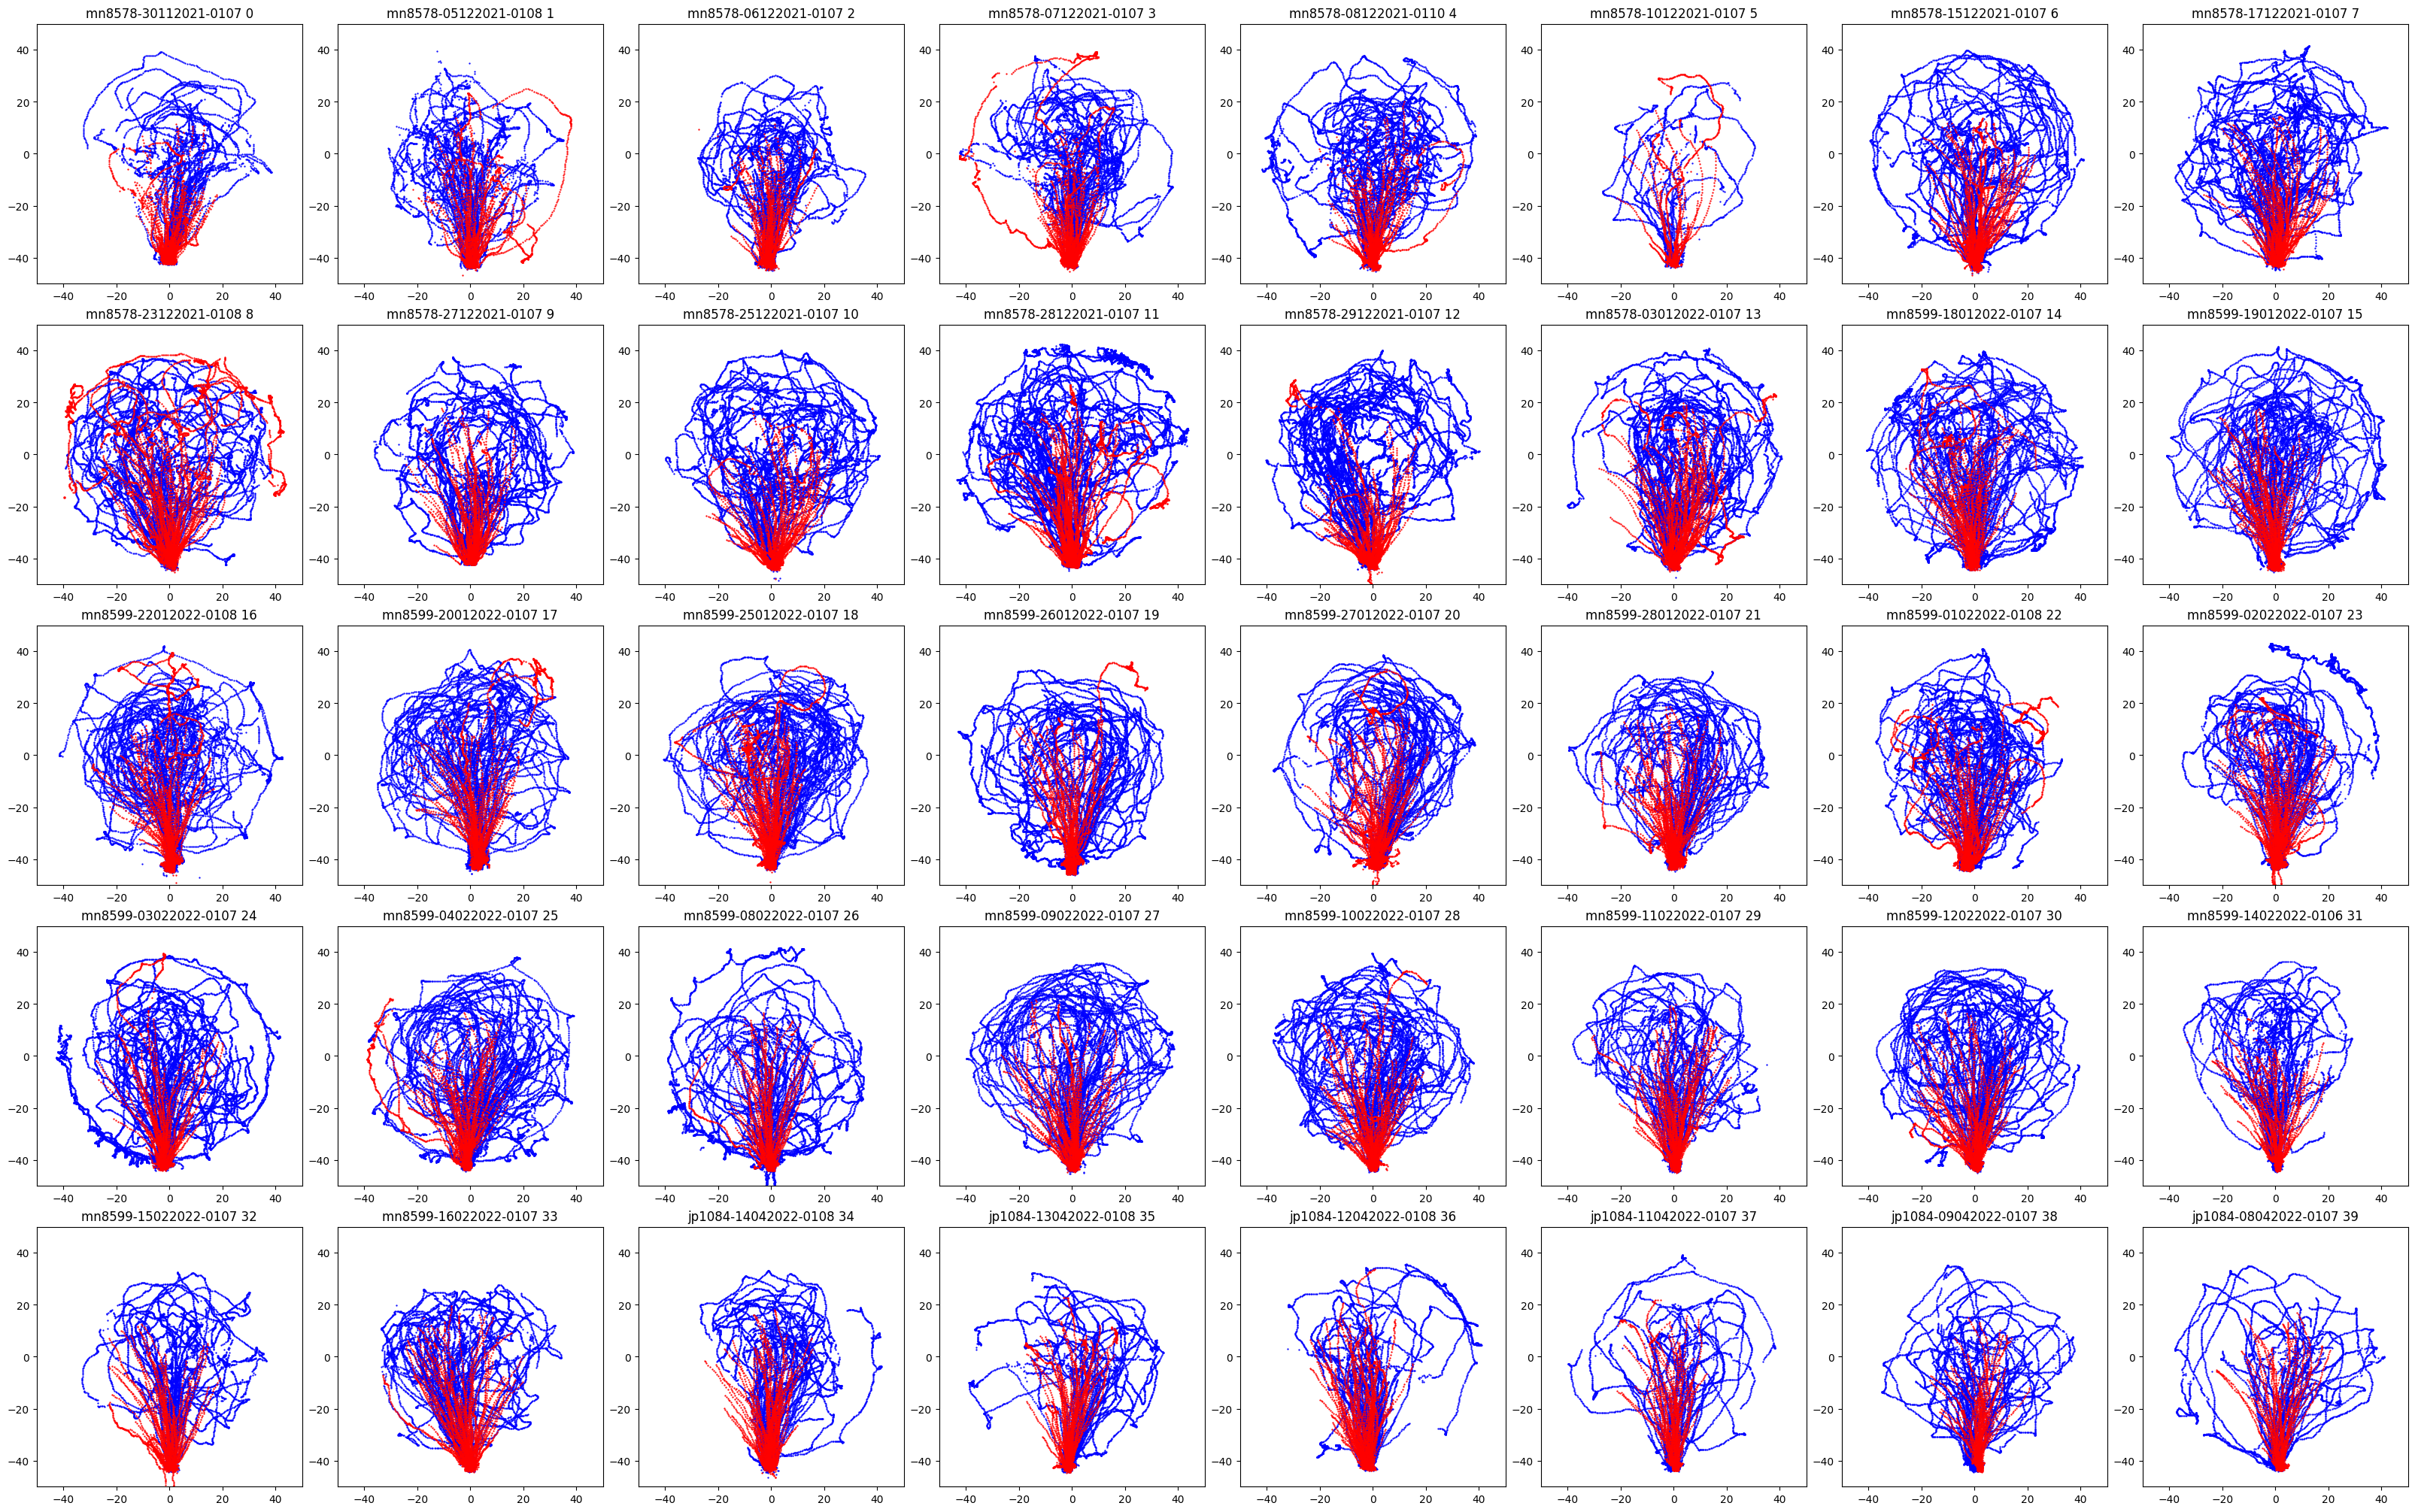

In [17]:
sizePerCol=4
sizePerRow=4
col = 8
row = 5
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gs = gridspec.GridSpec(row, col, figure=fig)


for i,s in enumerate(sessionList[:40]):
    y = int(i%col)
    x = int(i/col)
    ax = fig.add_subplot(gs[x,y])
    
    session = s.name
    
    sSes = [sSes for sSes in sSessions if sSes.name == session][0]
    ses = myProject.getSession(session)
    
    fn=ses.path+"/ses.pickle"
    with open(fn, 'rb') as handle:
        ses=pickle.load(handle)
        
    load_spikeA_one_session(sSes)
    
    getSearchHomingIntervals(ses,sSes)
    
    ifr, navs, inav = load_ifr_behavior(ses)
    
    sSes.ap.set_intervals(ses.intervalDict["searchToLeverPath_light"])
    ax.scatter(sSes.ap.pose[:,1],sSes.ap.pose[:,2],s=0.4,color="red",zorder=1)
    sSes.ap.set_intervals(ses.intervalDict["searchToLeverPath_dark"])
    ax.scatter(sSes.ap.pose[:,1],sSes.ap.pose[:,2],s=0.4,color="blue",zorder=0)
    
    
    ax.set_xlim(-50,50)
    ax.set_ylim(-50,50)
    ax.set_title(sSes.name+" {}".format(i))
plt.show()

# Get 1D histogram (similar to Maryam's paper)

** Copied from https://github.com/Mrymna/Jazi_et.al_2023_noInt/blob/main/fig4/search_path_data_collection.ipynb

We need to take into account 3 variables

distance run
lever distance (target Distance)
time run
y coordinate
Getting the data

These 3 behavioral variables can be extracted from the iNav DataFrame.

We can use the ses.intervalDict[] for the search path to get rid of spikes that are outside of the search paths.

We can take the iNav variable we want an put it in the spikeA.animal_pose object (as the x value). The res time is common to the 2 data sets

We can use the already available methods in spikeA to get info score and firing rate maps.

1D histogram binning

We need to have an equivalent binning for the 3 variables to be able to make valid comparisons. We want to compare between the 3 variables and between light and dark trials.

We can set the number of bins to 20. The minimal values can be set to 0 distance, 0 time and 10 cm distance to lever, -42 for y There are plenty of data at this extrem. The maximum value should be set to the .90 percentile of either light or dark trials, whichever is the lowest. This will get rid of bins with very low occupancy that tend to create spuriously high firing rate values. The range will kick out the data from search path in darkness with very long paths, to concentrate on the beginning of the path.

In [ ]:
sesIndex = 0
s = sessionList[sesIndex]
    
dfStats, resHisto = one_d_rate_histos_stats(s, pathType="searchToLeverPath",nbins = 15, behavioralVariables = ["distance","iTime","targetDistance","y"])

mn8578-30112021-0107 Number of neurons: 25


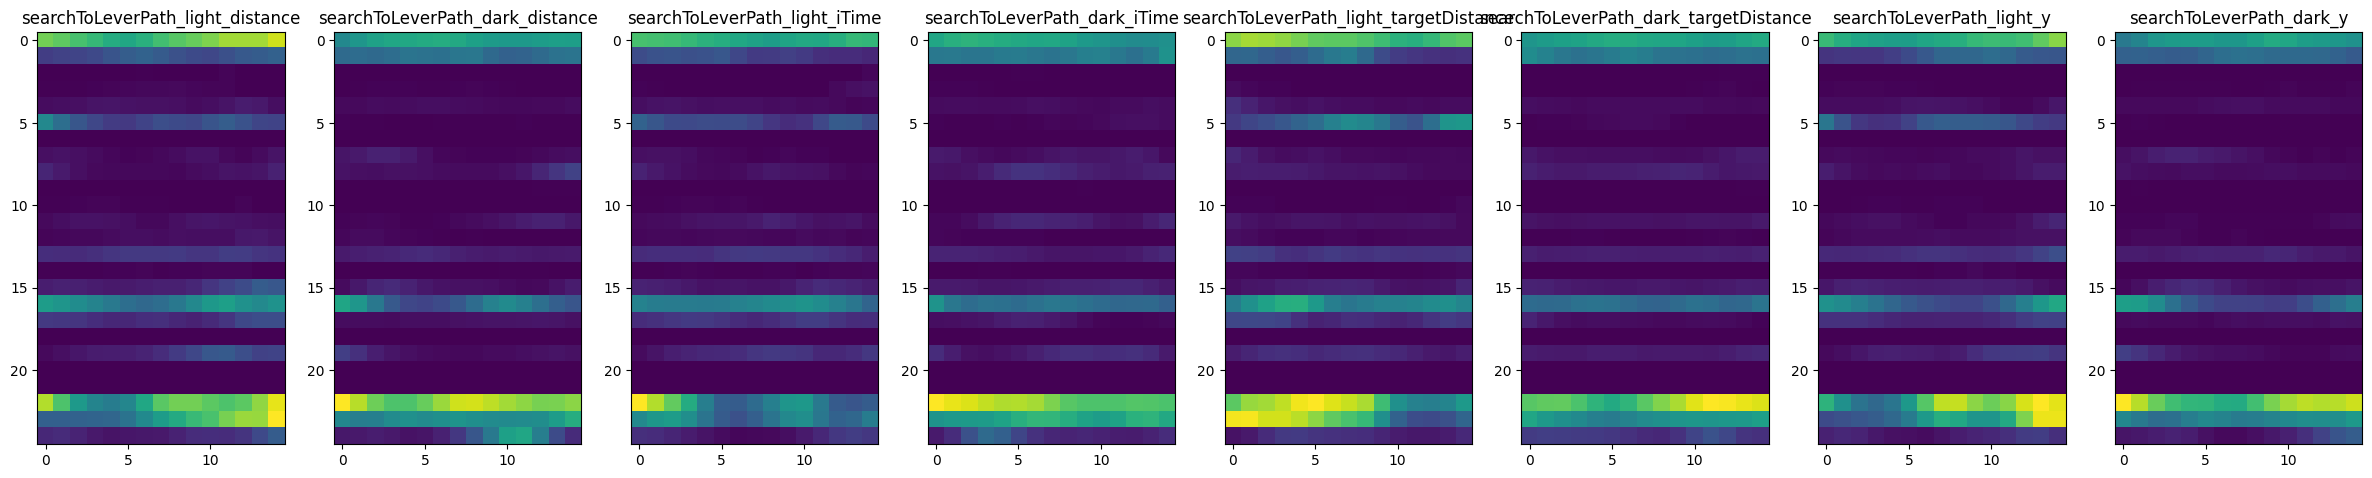

In [ ]:
nCond = len(resHisto.keys())
fig, axes = plt.subplots(1,nCond,figsize=(30,10))
        
for i,k in enumerate(resHisto.keys()):
    m = resHisto[k]
    axes[i].imshow(m)
    axes[i].set_title(k)

In [ ]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
%%time
res = [ one_d_rate_histos_stats(s,pathType="searchToLeverPath",nbins = 15, behavioralVariables = ["distance","iTime","targetDistance","y"]) for s in sessionList]

mn8578-30112021-0107 Number of neurons: 25
mn8578-05122021-0108 Number of neurons: 35
mn8578-06122021-0107 Number of neurons: 33
mn8578-07122021-0107 Number of neurons: 32
mn8578-08122021-0110 Number of neurons: 43
mn8578-10122021-0107 Number of neurons: 46
mn8578-15122021-0107 Number of neurons: 39
mn8578-17122021-0107 Number of neurons: 53
mn8578-23122021-0108 Number of neurons: 51
mn8578-27122021-0107 Number of neurons: 30
mn8578-25122021-0107 Number of neurons: 43
mn8578-28122021-0107 Number of neurons: 26
mn8578-29122021-0107 Number of neurons: 15
mn8578-03012022-0107 Number of neurons: 14
mn8599-18012022-0107 Number of neurons: 40
mn8599-19012022-0107 Number of neurons: 46
mn8599-22012022-0108 Number of neurons: 29
mn8599-20012022-0107 Number of neurons: 46
mn8599-25012022-0107 Number of neurons: 36
mn8599-26012022-0107 Number of neurons: 31
mn8599-27012022-0107 Number of neurons: 39
mn8599-28012022-0107 Number of neurons: 53
mn8599-01022022-0108 Number of neurons: 36
mn8599-0202

In [ ]:
dfStats = pd.concat([ s[0] for s in res])

In [ ]:
myRes = {}
for k in res[0][1]:
    myRes[k] = np.vstack([(s[1][k])for s in res])
print(myRes.keys())
myRes['searchToLeverPath_light_distance'].shape

dict_keys(['searchToLeverPath_light_distance', 'searchToLeverPath_dark_distance', 'searchToLeverPath_light_iTime', 'searchToLeverPath_dark_iTime', 'searchToLeverPath_light_targetDistance', 'searchToLeverPath_dark_targetDistance', 'searchToLeverPath_light_y', 'searchToLeverPath_dark_y'])


(10850, 15)

In [ ]:
# NOTE saving the data, uncomment when rerun

# fn=myProject.dataPath+"/results/1DsearchHisto.pickle"
# print("saving:",fn)
# with open(fn, 'wb') as handle:
#     pickle.dump(myRes, handle)

saving: /adata/projects/autopi_mec/results/1DsearchHisto.pickle


In [ ]:
# NOTE saving the data, uncomment when rerun

# fn=myProject.dataPath+"/results/1DsearchHistoStats.pickle"
# print("saving:",fn)
# with open(fn, 'wb') as handle:
#     pickle.dump(dfStats, handle)

saving: /adata/projects/autopi_mec/results/1DsearchHistoStats.pickle


# Plot single examples

In [ ]:
%%time
sesIndex = 8
s = sessionList[sesIndex]
res  =  journeyIFRMatrices(s)

number of neurons: 51
CPU times: user 5min 6s, sys: 335 ms, total: 5min 7s
Wall time: 5min 12s


(70, 243)


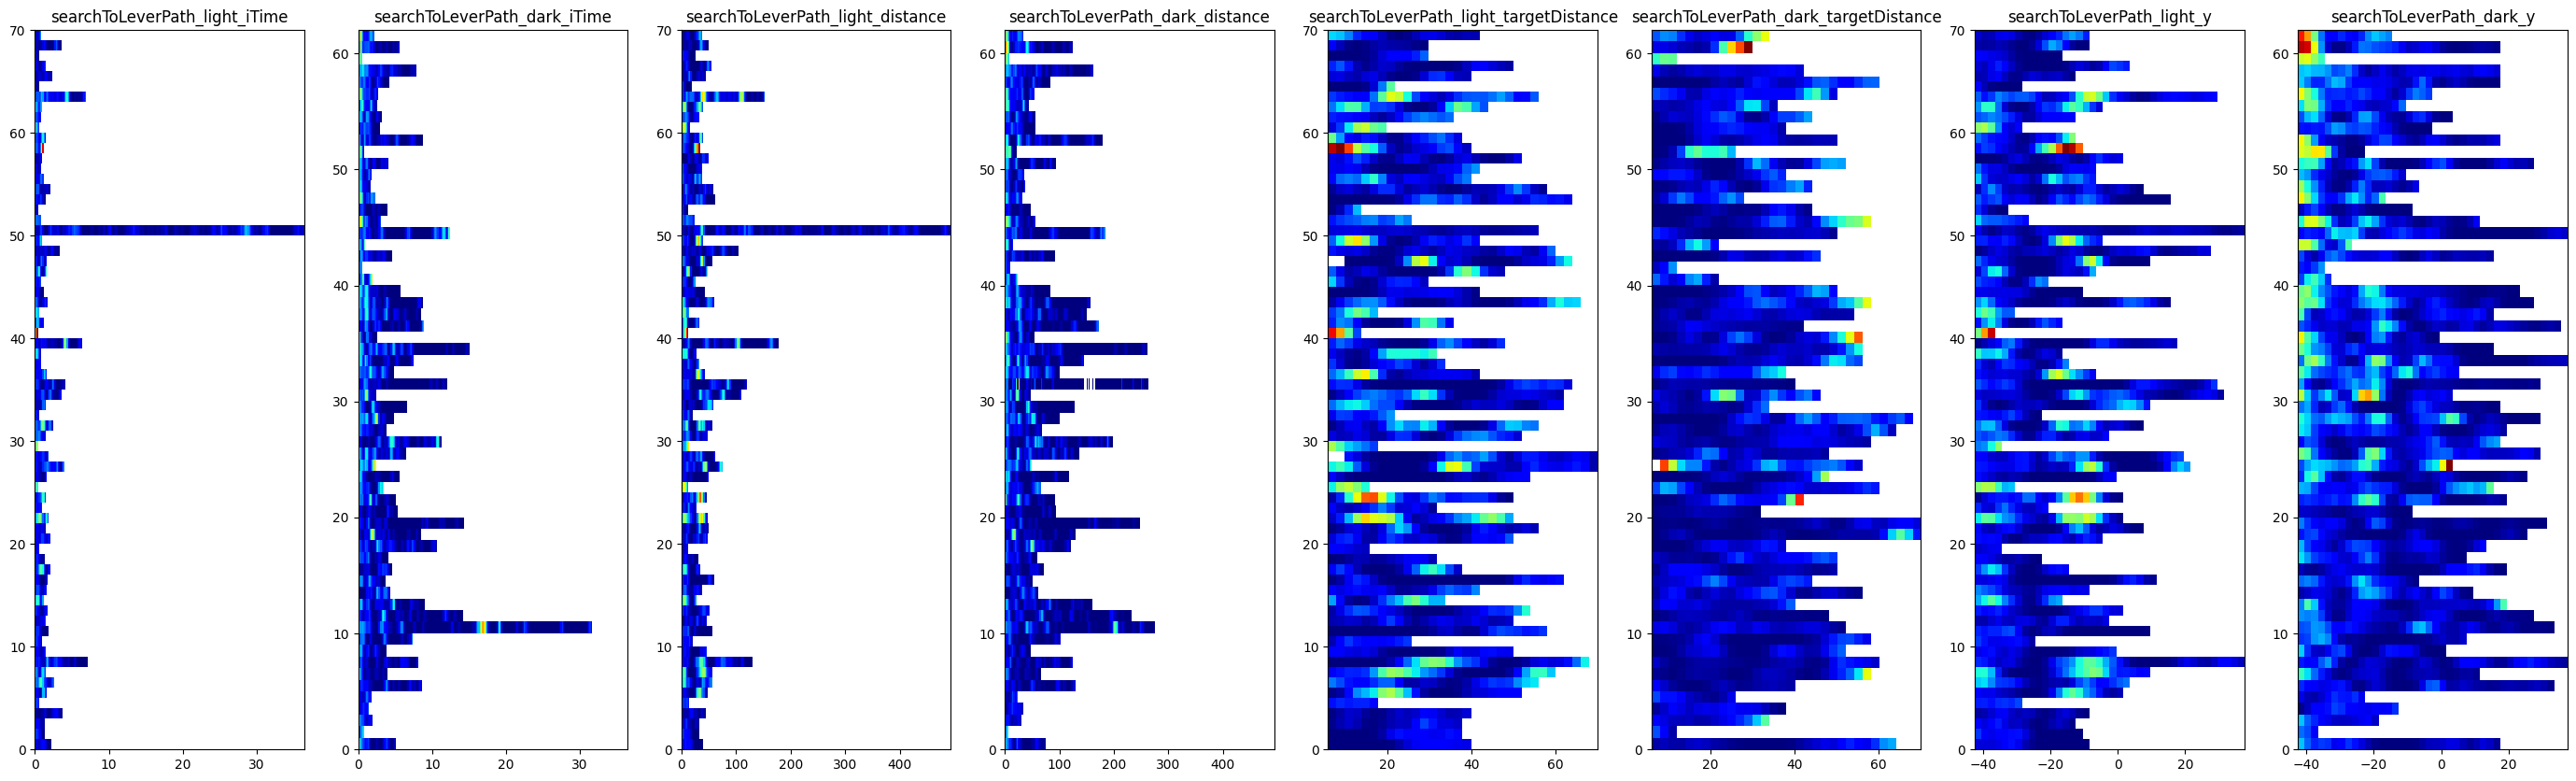

In [ ]:
M = res[list(res.keys())[6]]["matrix"]
nCond = len(M.keys())
fig, axes = plt.subplots(1,nCond,figsize=(35,10))
m = M[list(M.keys())[0]]["matrix"]
print(m.shape)

for i,k in enumerate(M.keys()) :
    # reorder the matrix rows according to number of np.nan
    m = M[k]["matrix"]
    
    axes[i].imshow(m ,interpolation="none",aspect="auto",extent=[np.min(M[k]["bins"]),np.max(M[k]["bins"]),0,m.shape[0]],origin="lower",cmap="jet")
    axes[i].set_title(k)

In [ ]:
%%time
res = [ journeyIFRMatrices(s) for s in sessionList]

number of neurons: 25
number of neurons: 35
number of neurons: 33
number of neurons: 32
number of neurons: 43
number of neurons: 46
number of neurons: 39
number of neurons: 53
number of neurons: 51
number of neurons: 30
number of neurons: 43
number of neurons: 26
number of neurons: 15
number of neurons: 14
number of neurons: 40
number of neurons: 46
number of neurons: 29
number of neurons: 46
number of neurons: 36
number of neurons: 31
number of neurons: 39
number of neurons: 53
number of neurons: 36
number of neurons: 46
number of neurons: 36
number of neurons: 27
number of neurons: 25
number of neurons: 31
number of neurons: 30
number of neurons: 44
number of neurons: 21
number of neurons: 35
number of neurons: 43
number of neurons: 50
number of neurons: 17
number of neurons: 26
number of neurons: 9
number of neurons: 14
number of neurons: 10
number of neurons: 13
number of neurons: 26
number of neurons: 32
number of neurons: 20
number of neurons: 17
number of neurons: 22
number of n

In [ ]:
newRes={}
for d in res:
    newRes.update(d)
print("Number of neurons: {}".format(len(newRes)))

Number of neurons: 10850


In [ ]:
# NOTE saving the data, uncomment when rerun

# fn=myProject.dataPath+"/results/searchIFRDict.pickle"
# print("saving:",fn)
# with open(fn, 'wb') as handle:
#     pickle.dump(newRes, handle)

saving: /adata/projects/autopi_mec/results/searchIFRDict.pickle


In [ ]:
print('we are done with the search_path calculation!')

we are done with the search_path calculation!


In [ ]:
print('Done!')

Done!


# Homing data collection

In [ ]:
sesIndex = 0
s = sessionList[sesIndex]
    
dfStats, resHisto = one_d_rate_histos_stats(s, pathType="homingFromLeavingLeverToPeriphery",nbins = 15, behavioralVariables = ["distance","iTime","targetDistance","y"])

mn8578-30112021-0107 Number of neurons: 25


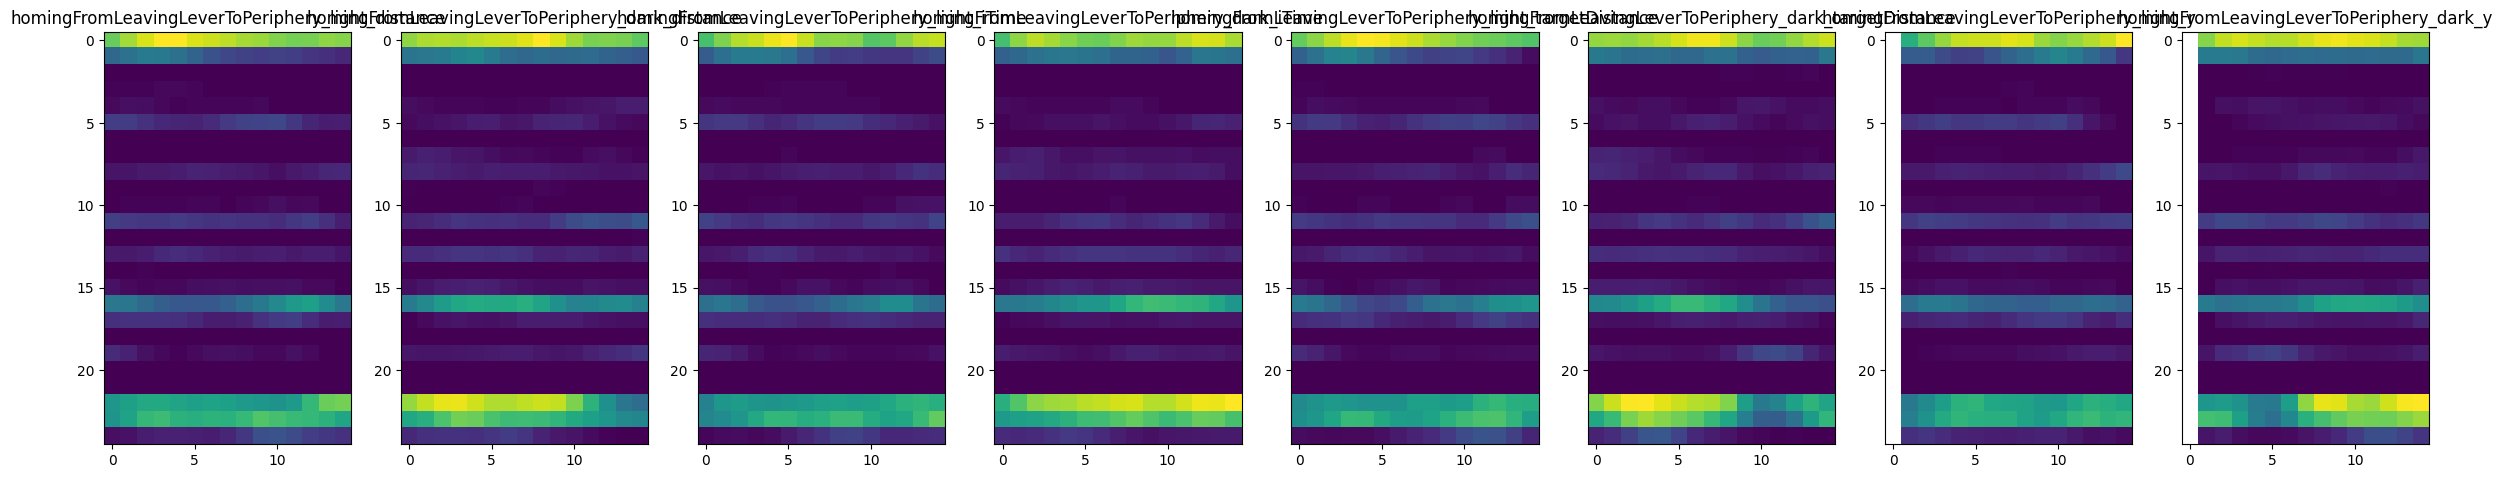

In [ ]:
nCond = len(resHisto.keys())
fig, axes = plt.subplots(1,nCond,figsize=(30,10))
        
for i,k in enumerate(resHisto.keys()):
    m = resHisto[k]
    axes[i].imshow(m)
    axes[i].set_title(k)

In [ ]:
import warnings

# Suppress the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
%%time
res = [ one_d_rate_histos_stats(s,pathType="homingFromLeavingLeverToPeriphery",nbins = 15, behavioralVariables = ["distance","iTime","targetDistance","y"]) for s in sessionList]

mn8578-30112021-0107 Number of neurons: 25
mn8578-05122021-0108 Number of neurons: 35
mn8578-06122021-0107 Number of neurons: 33
mn8578-07122021-0107 Number of neurons: 32
mn8578-08122021-0110 Number of neurons: 43
mn8578-10122021-0107 Number of neurons: 46
mn8578-15122021-0107 Number of neurons: 39
mn8578-17122021-0107 Number of neurons: 53
mn8578-23122021-0108 Number of neurons: 51
mn8578-27122021-0107 Number of neurons: 30
mn8578-25122021-0107 Number of neurons: 43
mn8578-28122021-0107 Number of neurons: 26
mn8578-29122021-0107 Number of neurons: 15
mn8578-03012022-0107 Number of neurons: 14
mn8599-18012022-0107 Number of neurons: 40
mn8599-19012022-0107 Number of neurons: 46
mn8599-22012022-0108 Number of neurons: 29
mn8599-20012022-0107 Number of neurons: 46
mn8599-25012022-0107 Number of neurons: 36
mn8599-26012022-0107 Number of neurons: 31
mn8599-27012022-0107 Number of neurons: 39
mn8599-28012022-0107 Number of neurons: 53
mn8599-01022022-0108 Number of neurons: 36
mn8599-0202

In [ ]:
dfStats = pd.concat([ s[0] for s in res])

In [ ]:
myRes = {}
for k in res[0][1]:
    myRes[k] = np.vstack([(s[1][k])for s in res])
print(myRes.keys())
myRes['homingFromLeavingLeverToPeriphery_light_distance'].shape

dict_keys(['homingFromLeavingLeverToPeriphery_light_distance', 'homingFromLeavingLeverToPeriphery_dark_distance', 'homingFromLeavingLeverToPeriphery_light_iTime', 'homingFromLeavingLeverToPeriphery_dark_iTime', 'homingFromLeavingLeverToPeriphery_light_targetDistance', 'homingFromLeavingLeverToPeriphery_dark_targetDistance', 'homingFromLeavingLeverToPeriphery_light_y', 'homingFromLeavingLeverToPeriphery_dark_y'])


(10850, 15)

In [ ]:
# NOTE saving the data, uncomment when rerun

# fn=myProject.dataPath+"/results/1DhomingHisto.pickle"
# print("saving:",fn)
# with open(fn, 'wb') as handle:
#     pickle.dump(myRes, handle)

saving: /adata/projects/autopi_mec/results/1DhomingHisto.pickle


In [ ]:
# NOTE saving the data, uncomment when rerun

# fn=myProject.dataPath+"/results/1DhomingHistoStats.pickle"
# print("saving:",fn)
# with open(fn, 'wb') as handle:
#     pickle.dump(dfStats, handle)

saving: /adata/projects/autopi_mec/results/1DhomingHistoStats.pickle


# IFR during homing paths

In [ ]:
def journeyIFRMatrices(s,navPathType="searchToLeverPath",smoothing=True):
    session = s.name
    
    sSes = [sSes for sSes in sSessions if sSes.name == session][0]
    ses = myProject.getSession(session)
    
    fn=ses.path+"/ses.pickle"
    with open(fn, 'rb') as handle:
        ses=pickle.load(handle)
        
    load_spikeA_one_session(sSes)

    getSearchHomingIntervals(ses,sSes)
    
    # load raw data from file
    ifr, navs, inav = load_ifr_behavior(ses)
    
    # create a list of NeuronAutopi object
    naList=[]
    for i, n in enumerate(sSes.cg.neuron_list):
        neuronIndex=i
        cluId = sSes.name+"_"+n.spike_train.name
        na = NeuronAutopi(name = cluId, ifr = (ifr[0][neuronIndex,:],ifr[1]),navPathSummary=navs,iNavPath=inav,trialElectro=ses.trialList[0])
        naList.append(na)
    
    print("number of neurons:",len(sSes.cg.neuron_list))
    
    selNames = navs[(navs.type == navPathType)].name
    inavSel = inav[inav.name.isin(selNames)]
    
    ############################################
    ## get the range that will cover all trials#
    ############################################
    minVals = {"iTime":0,
              "distance":0,
              "targetDistance":6,
              "y": -42.5}
    maxVals = {}
    for var in ["iTime","distance","targetDistance","y"]:
        ## find the maximal value for this variable
        maxVals[var] = np.nanmax(inavSel[var])
    
    valsPerBins = {"iTime":0.15, # tracking is at 50Hz
              "distance":2,
              "targetDistance":2,
              "y": 2}
    
    #print(minVals)
    #print(maxVals)
    #print(valsPerBins)
    
    # run the analysis
    for var in ["iTime","distance","targetDistance","y"]:
        for light in ["light","dark"]:
            for i, na in enumerate(naList):
                na.navPathBehavioralMatrix(navPathType=navPathType,light=light,nLeverMin = 1,
                                           behavioralVariable = var,bins=np.arange(minVals[var],maxVals[var],valsPerBins[var]),
                                           smoothing=smoothing,smoothingSigma=2) # per journey
                na.navPathBehavioralHistogram(navPathType=navPathType,light=light,nLeverMin = 1,behavioralVariable = var,bins=np.arange(minVals[var],maxVals[var],valsPerBins[var])) # all journeys together    
    # save the results
    sesRes={}
    for na in naList:
        sesRes[na.name] = na.navPathResultsDict
    
    return sesRes           

In [ ]:
%%time
sesIndex = 8
s = sessionList[sesIndex]
res  =  journeyIFRMatrices(s,navPathType='homingFromLeavingLeverToPeriphery') #homingFromLeavingLeverToPeriphery, searchToLeverPath

number of neurons: 51
CPU times: user 4min 55s, sys: 367 ms, total: 4min 56s
Wall time: 5min


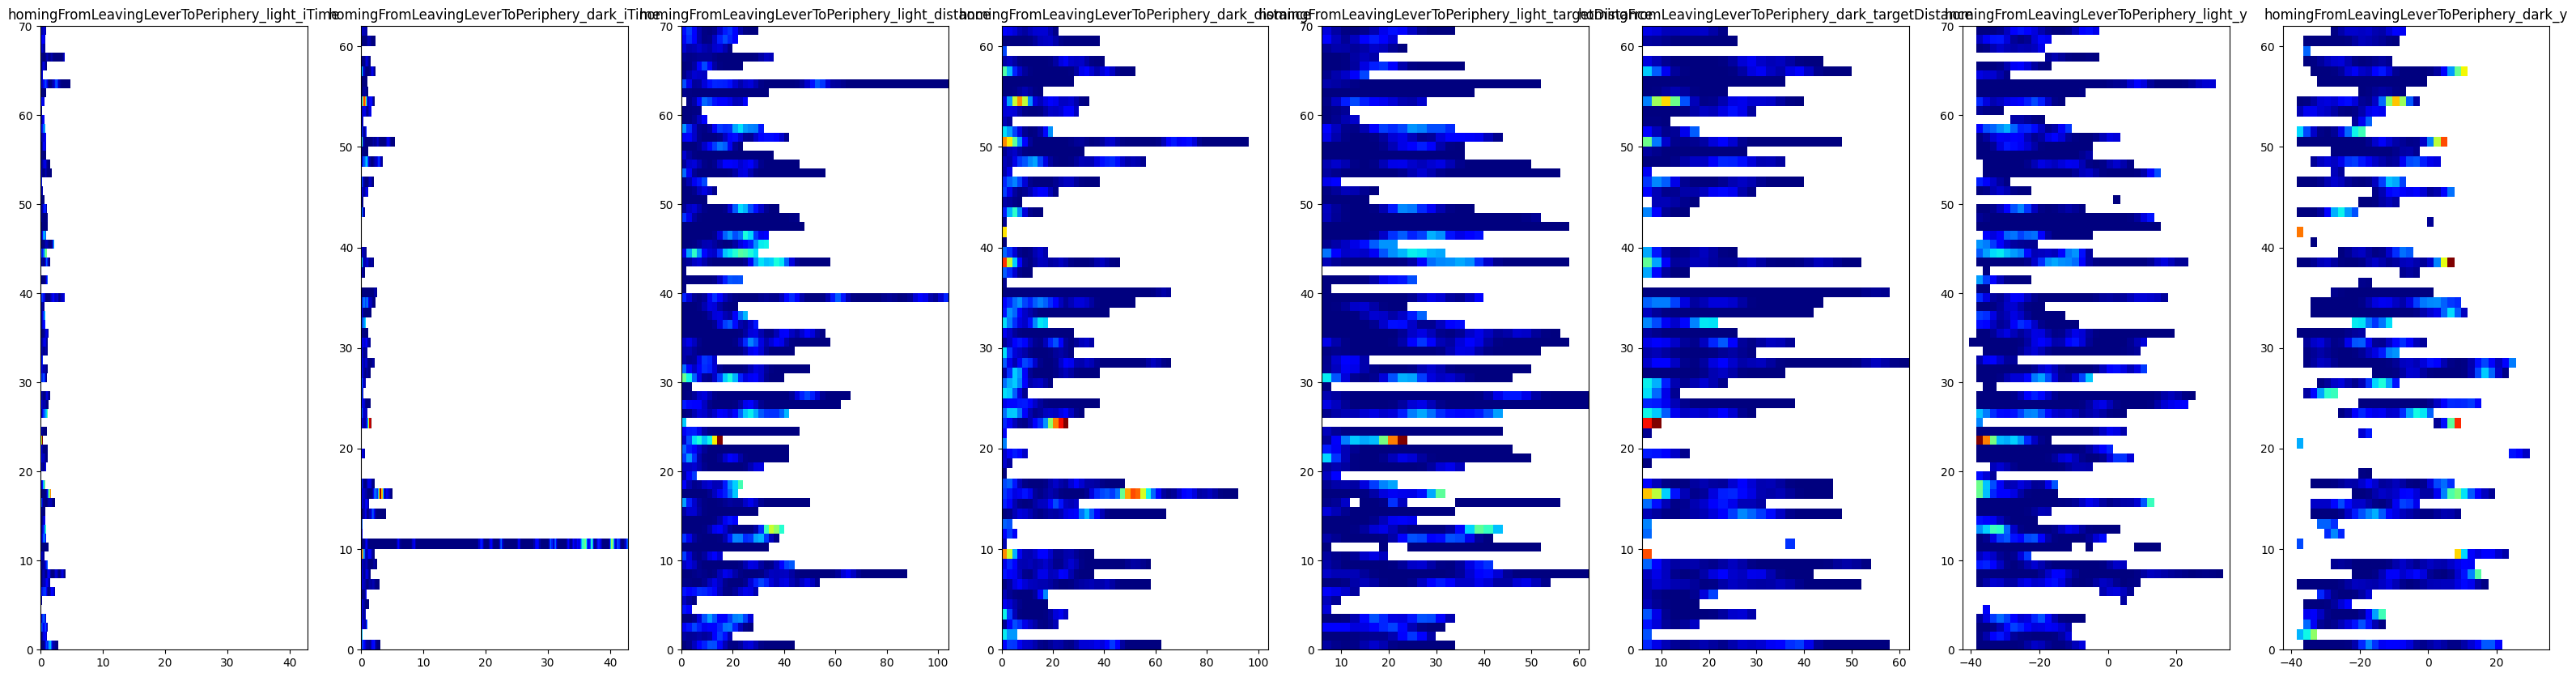

In [ ]:
M = res[list(res.keys())[6]]["matrix"]
nCond = len(M.keys())
fig, axes = plt.subplots(1,nCond,figsize=(40,10))

for i,k in enumerate(M.keys()) :
    # reorder the matrix rows according to number of np.nan
    m = M[k]["matrix"]
    axes[i].imshow(m ,interpolation="none",aspect="auto",extent=[np.min(M[k]["bins"]),np.max(M[k]["bins"]),0,m.shape[0]],origin="lower",cmap="jet")
    axes[i].set_title(k)

In [ ]:
%%time
res = [ journeyIFRMatrices(s,navPathType='homingFromLeavingLeverToPeriphery') for s in tqdm(sessionList,position=0)]

  0%|          | 0/180 [00:00<?, ?it/s]

number of neurons: 25


  1%|          | 1/180 [01:36<4:47:26, 96.35s/it]

number of neurons: 35


  1%|          | 2/180 [03:58<6:05:05, 123.06s/it]

number of neurons: 33


  2%|▏         | 3/180 [06:02<6:04:40, 123.62s/it]

number of neurons: 32


  2%|▏         | 4/180 [08:09<6:06:17, 124.87s/it]

number of neurons: 43


  3%|▎         | 5/180 [11:15<7:08:35, 146.95s/it]

number of neurons: 46


  3%|▎         | 6/180 [12:21<5:46:35, 119.51s/it]

number of neurons: 39


  4%|▍         | 7/180 [14:32<5:55:10, 123.18s/it]

number of neurons: 53


  4%|▍         | 8/180 [18:06<7:16:16, 152.19s/it]

number of neurons: 51


  5%|▌         | 9/180 [23:06<9:25:33, 198.44s/it]

number of neurons: 30


  6%|▌         | 10/180 [24:59<8:06:58, 171.88s/it]

number of neurons: 43


  6%|▌         | 11/180 [27:26<7:43:02, 164.39s/it]

number of neurons: 26


  7%|▋         | 12/180 [29:10<6:48:49, 146.01s/it]

number of neurons: 15


  7%|▋         | 13/180 [30:02<5:27:22, 117.62s/it]

number of neurons: 14


  8%|▊         | 14/180 [31:07<4:41:21, 101.70s/it]

number of neurons: 40


  8%|▊         | 15/180 [34:30<6:03:37, 132.23s/it]

number of neurons: 46


  9%|▉         | 16/180 [37:59<7:04:29, 155.30s/it]

number of neurons: 29


  9%|▉         | 17/180 [40:07<6:39:47, 147.16s/it]

number of neurons: 46


 10%|█         | 18/180 [43:31<7:23:23, 164.22s/it]

number of neurons: 36


 11%|█         | 19/180 [46:29<7:31:20, 168.20s/it]

number of neurons: 31


 11%|█         | 20/180 [48:08<6:33:40, 147.63s/it]

number of neurons: 39


 12%|█▏        | 21/180 [51:30<7:14:30, 163.97s/it]

number of neurons: 53


 12%|█▏        | 22/180 [55:50<8:27:33, 192.74s/it]

number of neurons: 36


 13%|█▎        | 23/180 [58:10<7:43:05, 176.98s/it]

number of neurons: 46


 13%|█▎        | 24/180 [1:02:18<8:35:22, 198.22s/it]

number of neurons: 36


 14%|█▍        | 25/180 [1:04:29<7:39:43, 177.96s/it]

number of neurons: 27


 14%|█▍        | 26/180 [1:06:44<7:03:29, 165.00s/it]

number of neurons: 25


 15%|█▌        | 27/180 [1:08:08<5:58:41, 140.67s/it]

number of neurons: 31


 16%|█▌        | 28/180 [1:10:37<6:02:48, 143.22s/it]

number of neurons: 30


 16%|█▌        | 29/180 [1:12:45<5:49:17, 138.79s/it]

number of neurons: 44


 17%|█▋        | 30/180 [1:16:04<6:32:16, 156.91s/it]

number of neurons: 21


 17%|█▋        | 31/180 [1:17:57<5:56:45, 143.66s/it]

number of neurons: 35


 18%|█▊        | 32/180 [1:19:24<5:12:01, 126.49s/it]

number of neurons: 43


 18%|█▊        | 33/180 [1:22:15<5:43:06, 140.05s/it]

number of neurons: 50


 19%|█▉        | 34/180 [1:26:07<6:47:33, 167.49s/it]

number of neurons: 17


 19%|█▉        | 35/180 [1:27:40<5:50:34, 145.06s/it]

number of neurons: 26


 20%|██        | 36/180 [1:29:27<5:20:58, 133.74s/it]

number of neurons: 9


 21%|██        | 37/180 [1:30:20<4:21:19, 109.64s/it]

number of neurons: 14


 21%|██        | 38/180 [1:31:05<3:33:32, 90.23s/it] 

number of neurons: 10


 22%|██▏       | 39/180 [1:31:40<2:52:42, 73.49s/it]

number of neurons: 13


 22%|██▏       | 40/180 [1:32:18<2:27:11, 63.08s/it]

number of neurons: 26


 23%|██▎       | 41/180 [1:33:37<2:37:06, 67.81s/it]

number of neurons: 32


 23%|██▎       | 42/180 [1:35:18<2:58:45, 77.72s/it]

number of neurons: 20


 24%|██▍       | 43/180 [1:35:59<2:32:09, 66.64s/it]

number of neurons: 17


 24%|██▍       | 44/180 [1:36:47<2:18:28, 61.09s/it]

number of neurons: 22


 25%|██▌       | 45/180 [1:38:00<2:25:35, 64.71s/it]

number of neurons: 30


 26%|██▌       | 46/180 [1:38:59<2:20:23, 62.86s/it]

number of neurons: 46


 26%|██▌       | 47/180 [1:41:52<3:32:50, 96.02s/it]

number of neurons: 78


 27%|██▋       | 48/180 [1:46:24<5:27:06, 148.68s/it]

number of neurons: 44


 27%|██▋       | 49/180 [1:48:46<5:20:08, 146.63s/it]

number of neurons: 60


 28%|██▊       | 50/180 [1:52:45<6:17:47, 174.37s/it]

number of neurons: 40


 28%|██▊       | 51/180 [1:55:17<6:00:35, 167.72s/it]

number of neurons: 53


 29%|██▉       | 52/180 [1:57:36<5:39:27, 159.12s/it]

number of neurons: 73


 29%|██▉       | 53/180 [2:02:42<7:09:56, 203.12s/it]

number of neurons: 53


 30%|███       | 54/180 [2:06:12<7:11:22, 205.41s/it]

number of neurons: 35


 31%|███       | 55/180 [2:08:15<6:16:26, 180.69s/it]

number of neurons: 21


 31%|███       | 56/180 [2:10:24<5:41:02, 165.02s/it]

number of neurons: 30


 32%|███▏      | 57/180 [2:13:03<5:34:29, 163.17s/it]

number of neurons: 33


 32%|███▏      | 58/180 [2:14:16<4:37:03, 136.26s/it]

number of neurons: 60


 33%|███▎      | 59/180 [2:18:50<5:57:44, 177.39s/it]

number of neurons: 75


 33%|███▎      | 60/180 [2:23:03<6:40:36, 200.31s/it]

number of neurons: 75


 34%|███▍      | 61/180 [2:27:57<7:32:42, 228.26s/it]

number of neurons: 93


 34%|███▍      | 62/180 [2:34:26<9:03:42, 276.46s/it]

number of neurons: 56


 35%|███▌      | 63/180 [2:38:53<8:53:47, 273.74s/it]

number of neurons: 67


 36%|███▌      | 64/180 [2:43:32<8:52:26, 275.40s/it]

number of neurons: 70


 36%|███▌      | 65/180 [2:48:16<8:52:38, 277.90s/it]

number of neurons: 57


 37%|███▋      | 66/180 [2:51:55<8:14:22, 260.20s/it]

number of neurons: 28


 37%|███▋      | 67/180 [2:53:54<6:50:04, 217.74s/it]

number of neurons: 71


 38%|███▊      | 68/180 [2:58:52<7:31:30, 241.88s/it]

number of neurons: 68


 38%|███▊      | 69/180 [3:03:50<7:58:35, 258.70s/it]

number of neurons: 43


 39%|███▉      | 70/180 [3:06:52<7:12:13, 235.76s/it]

number of neurons: 42


 39%|███▉      | 71/180 [3:10:09<6:47:07, 224.10s/it]

number of neurons: 51


 40%|████      | 72/180 [3:13:21<6:26:04, 214.48s/it]

number of neurons: 44


 41%|████      | 73/180 [3:16:47<6:17:39, 211.77s/it]

number of neurons: 23


 41%|████      | 74/180 [3:18:42<5:23:18, 183.01s/it]

number of neurons: 15


 42%|████▏     | 75/180 [3:20:10<4:30:19, 154.47s/it]

number of neurons: 15


 42%|████▏     | 76/180 [3:22:15<4:12:28, 145.66s/it]

number of neurons: 22


 43%|████▎     | 77/180 [3:24:18<3:58:21, 138.84s/it]

number of neurons: 56


 43%|████▎     | 78/180 [3:29:19<5:18:26, 187.31s/it]

number of neurons: 77


 44%|████▍     | 79/180 [3:34:52<6:28:55, 231.05s/it]

number of neurons: 68


 44%|████▍     | 80/180 [3:39:01<6:34:00, 236.40s/it]

number of neurons: 33


 45%|████▌     | 81/180 [3:41:51<5:57:30, 216.67s/it]

number of neurons: 107


 46%|████▌     | 82/180 [3:47:41<6:59:04, 256.57s/it]

number of neurons: 81


 46%|████▌     | 83/180 [3:52:39<7:15:03, 269.11s/it]

number of neurons: 83


 47%|████▋     | 84/180 [4:00:10<8:37:42, 323.56s/it]

number of neurons: 68


 47%|████▋     | 85/180 [4:06:37<9:02:28, 342.61s/it]

number of neurons: 66


 48%|████▊     | 86/180 [4:11:43<8:39:43, 331.74s/it]

number of neurons: 91


 48%|████▊     | 87/180 [4:17:15<8:34:17, 331.80s/it]

number of neurons: 65


 49%|████▉     | 88/180 [4:22:26<8:19:10, 325.55s/it]

number of neurons: 61


 49%|████▉     | 89/180 [4:29:19<8:53:22, 351.68s/it]

number of neurons: 62


 50%|█████     | 90/180 [4:34:08<8:19:11, 332.79s/it]

number of neurons: 85


 51%|█████     | 91/180 [4:45:04<10:37:33, 429.82s/it]

number of neurons: 65


 51%|█████     | 92/180 [4:51:02<9:58:44, 408.23s/it] 

number of neurons: 104


 52%|█████▏    | 93/180 [4:57:36<9:45:41, 403.93s/it]

number of neurons: 66


 52%|█████▏    | 94/180 [5:02:46<8:58:38, 375.80s/it]

number of neurons: 60


 53%|█████▎    | 95/180 [5:06:45<7:54:25, 334.89s/it]

number of neurons: 6


 53%|█████▎    | 96/180 [5:07:24<5:44:19, 245.95s/it]

number of neurons: 74


 54%|█████▍    | 97/180 [5:12:52<6:14:35, 270.78s/it]

number of neurons: 71


 54%|█████▍    | 98/180 [5:18:20<6:33:17, 287.78s/it]

number of neurons: 47


 55%|█████▌    | 99/180 [5:20:52<5:33:40, 247.17s/it]

number of neurons: 72


 56%|█████▌    | 100/180 [5:27:14<6:23:14, 287.43s/it]

number of neurons: 61


 56%|█████▌    | 101/180 [5:33:44<6:58:59, 318.22s/it]

number of neurons: 41


 57%|█████▋    | 102/180 [5:36:30<5:54:30, 272.69s/it]

number of neurons: 76


 57%|█████▋    | 103/180 [5:46:16<7:50:41, 366.77s/it]

number of neurons: 49


 58%|█████▊    | 104/180 [5:49:03<6:28:32, 306.75s/it]

number of neurons: 42


 58%|█████▊    | 105/180 [5:52:40<5:49:38, 279.72s/it]

number of neurons: 97


 59%|█████▉    | 106/180 [6:01:12<7:10:56, 349.42s/it]

number of neurons: 103


 59%|█████▉    | 107/180 [6:06:49<7:00:35, 345.69s/it]

number of neurons: 77


 60%|██████    | 108/180 [6:12:30<6:53:12, 344.34s/it]

number of neurons: 54


 61%|██████    | 109/180 [6:14:50<5:34:53, 283.01s/it]

number of neurons: 55


 61%|██████    | 110/180 [6:19:11<5:22:29, 276.42s/it]

number of neurons: 63


 62%|██████▏   | 111/180 [6:23:42<5:16:07, 274.89s/it]

number of neurons: 50


 62%|██████▏   | 112/180 [6:28:41<5:19:39, 282.05s/it]

number of neurons: 66


 63%|██████▎   | 113/180 [6:35:08<5:50:15, 313.66s/it]

number of neurons: 54


 63%|██████▎   | 114/180 [6:40:43<5:51:49, 319.85s/it]

number of neurons: 74


 64%|██████▍   | 115/180 [6:45:05<5:27:40, 302.47s/it]

number of neurons: 68


 64%|██████▍   | 116/180 [6:50:36<5:31:51, 311.11s/it]

number of neurons: 74


 65%|██████▌   | 117/180 [6:55:51<5:27:53, 312.27s/it]

number of neurons: 65


 66%|██████▌   | 118/180 [6:59:58<5:02:28, 292.72s/it]

number of neurons: 63


 66%|██████▌   | 119/180 [7:03:35<4:34:27, 269.95s/it]

number of neurons: 40


 67%|██████▋   | 120/180 [7:06:11<3:55:45, 235.76s/it]

number of neurons: 48


 67%|██████▋   | 121/180 [7:10:45<4:03:10, 247.30s/it]

number of neurons: 86


 68%|██████▊   | 122/180 [7:21:34<5:55:33, 367.82s/it]

number of neurons: 93


 68%|██████▊   | 123/180 [7:31:29<6:54:08, 435.95s/it]

number of neurons: 82


 69%|██████▉   | 124/180 [7:38:13<6:37:54, 426.32s/it]

number of neurons: 80


 69%|██████▉   | 125/180 [7:46:00<6:42:04, 438.63s/it]

number of neurons: 38


 70%|███████   | 126/180 [7:49:36<5:34:32, 371.71s/it]

number of neurons: 29


 71%|███████   | 127/180 [7:52:19<4:33:04, 309.15s/it]

number of neurons: 51


 71%|███████   | 128/180 [7:57:41<4:31:19, 313.07s/it]

number of neurons: 178


 72%|███████▏  | 129/180 [8:15:49<7:43:46, 545.62s/it]

number of neurons: 148


 72%|███████▏  | 130/180 [8:25:57<7:50:10, 564.20s/it]

number of neurons: 167


 73%|███████▎  | 131/180 [8:42:56<9:32:16, 700.75s/it]

number of neurons: 165


 73%|███████▎  | 132/180 [8:56:27<9:46:56, 733.68s/it]

number of neurons: 117


 74%|███████▍  | 133/180 [9:09:26<9:45:25, 747.35s/it]

number of neurons: 168


 74%|███████▍  | 134/180 [9:25:31<10:23:00, 812.61s/it]

number of neurons: 177


 75%|███████▌  | 135/180 [9:41:48<10:46:29, 861.98s/it]

number of neurons: 198


 76%|███████▌  | 136/180 [10:02:58<12:01:56, 984.46s/it]

number of neurons: 185


 76%|███████▌  | 137/180 [10:18:04<11:28:35, 960.83s/it]

number of neurons: 135


 77%|███████▋  | 138/180 [10:29:19<10:12:33, 875.09s/it]

number of neurons: 112


 77%|███████▋  | 139/180 [10:41:40<9:30:26, 834.79s/it] 

number of neurons: 106


 78%|███████▊  | 140/180 [10:53:59<8:57:19, 805.98s/it]

number of neurons: 190


 78%|███████▊  | 141/180 [11:04:44<8:12:28, 757.65s/it]

number of neurons: 3


 79%|███████▉  | 142/180 [11:05:04<5:39:50, 536.60s/it]

number of neurons: 135


 79%|███████▉  | 143/180 [11:20:31<6:43:07, 653.72s/it]

number of neurons: 98


 80%|████████  | 144/180 [11:29:58<6:16:29, 627.48s/it]

number of neurons: 100


 81%|████████  | 145/180 [11:38:45<5:48:36, 597.60s/it]

number of neurons: 71


 81%|████████  | 146/180 [11:44:20<4:53:56, 518.72s/it]

number of neurons: 128


 82%|████████▏ | 147/180 [11:57:50<5:33:19, 606.04s/it]

number of neurons: 160


 82%|████████▏ | 148/180 [12:13:31<6:16:49, 706.56s/it]

number of neurons: 124


 83%|████████▎ | 149/180 [12:26:08<6:12:51, 721.65s/it]

number of neurons: 126


 83%|████████▎ | 150/180 [12:39:45<6:15:08, 750.29s/it]

number of neurons: 52


 84%|████████▍ | 151/180 [12:45:08<5:00:37, 622.00s/it]

number of neurons: 131


 84%|████████▍ | 152/180 [12:56:47<5:01:07, 645.26s/it]

number of neurons: 140


 85%|████████▌ | 153/180 [13:11:52<5:25:25, 723.17s/it]

number of neurons: 127


 86%|████████▌ | 154/180 [13:19:08<4:36:04, 637.11s/it]

number of neurons: 58


 86%|████████▌ | 155/180 [13:24:33<3:46:25, 543.44s/it]

number of neurons: 59


 87%|████████▋ | 156/180 [13:28:01<2:57:04, 442.69s/it]

number of neurons: 15


 87%|████████▋ | 157/180 [13:28:53<2:04:49, 325.63s/it]

number of neurons: 43


 88%|████████▊ | 158/180 [13:34:03<1:57:35, 320.68s/it]

number of neurons: 44


 88%|████████▊ | 159/180 [13:37:08<1:38:03, 280.19s/it]

number of neurons: 32


 89%|████████▉ | 160/180 [13:39:08<1:17:23, 232.17s/it]

number of neurons: 8


 89%|████████▉ | 161/180 [13:39:39<54:20, 171.60s/it]  

number of neurons: 6


 90%|█████████ | 162/180 [13:40:07<38:33, 128.55s/it]

number of neurons: 33


 91%|█████████ | 163/180 [13:43:08<40:55, 144.43s/it]

number of neurons: 19


 91%|█████████ | 164/180 [13:44:23<32:57, 123.59s/it]

number of neurons: 45


 92%|█████████▏| 165/180 [13:47:01<33:29, 133.94s/it]

number of neurons: 22


 92%|█████████▏| 166/180 [13:48:56<29:53, 128.08s/it]

number of neurons: 78


 93%|█████████▎| 167/180 [13:54:30<41:07, 189.81s/it]

number of neurons: 42


 93%|█████████▎| 168/180 [13:57:12<36:20, 181.73s/it]

number of neurons: 28


 94%|█████████▍| 169/180 [13:59:08<29:41, 161.95s/it]

number of neurons: 37


 94%|█████████▍| 170/180 [14:01:16<25:16, 151.62s/it]

number of neurons: 53


 95%|█████████▌| 171/180 [14:05:21<26:58, 179.78s/it]

number of neurons: 63


 96%|█████████▌| 172/180 [14:08:51<25:10, 188.86s/it]

number of neurons: 41


 96%|█████████▌| 173/180 [14:13:14<24:36, 210.88s/it]

number of neurons: 47


 97%|█████████▋| 174/180 [14:17:04<21:40, 216.82s/it]

number of neurons: 51


 97%|█████████▋| 175/180 [14:21:34<19:24, 232.83s/it]

number of neurons: 52


 98%|█████████▊| 176/180 [14:26:59<17:21, 260.33s/it]

number of neurons: 56


 98%|█████████▊| 177/180 [14:31:20<13:01, 260.49s/it]

number of neurons: 14


 99%|█████████▉| 178/180 [14:32:35<06:49, 204.98s/it]

number of neurons: 62


 99%|█████████▉| 179/180 [14:37:49<03:57, 237.60s/it]

number of neurons: 48


100%|██████████| 180/180 [14:41:43<00:00, 293.91s/it]

CPU times: user 14h 29min 6s, sys: 2min 2s, total: 14h 31min 8s
Wall time: 14h 41min 43s


In [ ]:
newRes={}
for d in res:
    newRes.update(d)
print("Number of neurons: {}".format(len(newRes)))

Number of neurons: 10850


In [ ]:
# fn=myProject.dataPath+"/results/homingIFRDict.pickle"
# print("saving:",fn)
# with open(fn, 'wb') as handle:
#     pickle.dump(newRes, handle)

saving: /adata/projects/autopi_mec/results/homingIFRDict.pickle
